<a href="https://colab.research.google.com/github/avirooppal/Differential-Privacy-in-Federated-Learning/blob/main/FL_DP_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install matplotlib scikit-learn torch numpy torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00


Round 1/30 - Test Acc: 0.6667
Round 2/30 - Test Acc: 0.7105
Round 3/30 - Test Acc: 0.8070
Round 4/30 - Test Acc: 0.8421
Round 5/30 - Test Acc: 0.8947
Round 6/30 - Test Acc: 0.8947
Round 7/30 - Test Acc: 0.9035
Round 8/30 - Test Acc: 0.9123
Round 9/30 - Test Acc: 0.9298
Round 10/30 - Test Acc: 0.9298
Round 11/30 - Test Acc: 0.9298
Round 12/30 - Test Acc: 0.9386
Round 13/30 - Test Acc: 0.9386
Round 14/30 - Test Acc: 0.9386
Round 15/30 - Test Acc: 0.9386
Round 16/30 - Test Acc: 0.9386
Round 17/30 - Test Acc: 0.9386
Round 18/30 - Test Acc: 0.9386
Round 19/30 - Test Acc: 0.9386
Round 20/30 - Test Acc: 0.9386
Round 21/30 - Test Acc: 0.9386
Round 22/30 - Test Acc: 0.9386
Round 23/30 - Test Acc: 0.9386
Round 24/30 - Test Acc: 0.9386
Round 25/30 - Test Acc: 0.9386
Round 26/30 - Test Acc: 0.9386
Round 27/30 - Test Acc: 0.9386
Round 28/30 - Test Acc: 0.9386
Round 29/30 - Test Acc: 0.9386
Round 30/30 - Test Acc: 0.9386


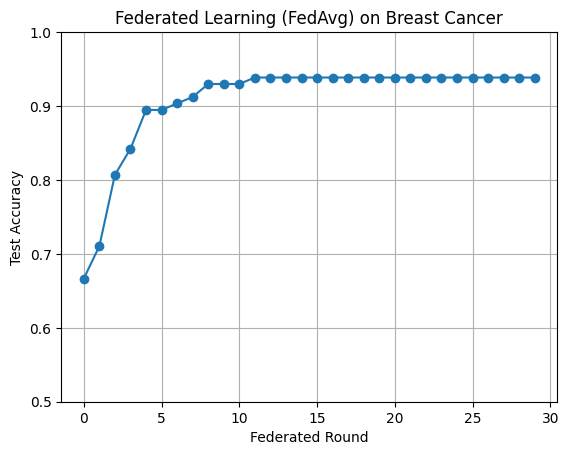

Final FL accuracy: 0.9385964870452881


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(42)
np.random.seed(42)

# -----------------------
# Dataset
# -----------------------
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.int64)

# Standardize
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# -----------------------
# Simple model (MLP)
# -----------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden=32, out_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------------
# Federated training (FedAvg)
# -----------------------
def fedavg_train(num_clients=5, num_rounds=30, local_epochs=2):
    # Split data IID among clients
    idxs = np.arange(len(X_train))
    np.random.shuffle(idxs)
    client_splits = np.array_split(idxs, num_clients)

    # Init global model
    global_model = SimpleMLP(X.shape[1])
    global_params = [p.detach().clone() for p in global_model.parameters()]

    test_accs = []

    for r in range(num_rounds):
        client_updates = []
        # Each client trains locally
        for split in client_splits:
            model = SimpleMLP(X.shape[1])
            # load global params
            for p, q in zip(model.parameters(), global_params):
                p.data.copy_(q)

            opt = optim.SGD(model.parameters(), lr=0.05)
            for _ in range(local_epochs):
                xb, yb = X_train[split], y_train[split]
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()

            # compute update
            local_params = [p.detach().clone() for p in model.parameters()]
            update = [lp - gp for lp, gp in zip(local_params, global_params)]
            client_updates.append(update)

        # Aggregate updates (average)
        agg_update = [sum(up[i] for up in client_updates) / num_clients
                      for i in range(len(global_params))]

        # Update global params
        global_params = [gp + au for gp, au in zip(global_params, agg_update)]

        # Evaluate on test set
        global_model.eval()
        with torch.no_grad():
            for p, q in zip(global_model.parameters(), global_params):
                p.data.copy_(q)
            preds = global_model(X_test).argmax(dim=1)
            acc = (preds == y_test).float().mean().item()
        test_accs.append(acc)

        print(f"Round {r+1}/{num_rounds} - Test Acc: {acc:.4f}")

    return test_accs

# -----------------------
# Run FL
# -----------------------
accs = fedavg_train(num_clients=5, num_rounds=30, local_epochs=2)

# -----------------------
# Plot results
# -----------------------
plt.plot(accs, marker="o")
plt.xlabel("Federated Round")
plt.ylabel("Test Accuracy")
plt.title("Federated Learning (FedAvg) on Breast Cancer")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()
accs_fl = accs   # keep the whole list
acc_fl = accs[-1]   # also store final accuracy
   # save the final FedAvg accuracy
print("Final FL accuracy:", acc_fl)


Running FL+DP with noise multiplier = 0.0
Round 1/30 - Test Acc: 0.6667
Round 2/30 - Test Acc: 0.7105
Round 3/30 - Test Acc: 0.8070
Round 4/30 - Test Acc: 0.8421
Round 5/30 - Test Acc: 0.8947
Round 6/30 - Test Acc: 0.8947
Round 7/30 - Test Acc: 0.9035
Round 8/30 - Test Acc: 0.9123
Round 9/30 - Test Acc: 0.9298
Round 10/30 - Test Acc: 0.9298
Round 11/30 - Test Acc: 0.9298
Round 12/30 - Test Acc: 0.9386
Round 13/30 - Test Acc: 0.9386
Round 14/30 - Test Acc: 0.9386
Round 15/30 - Test Acc: 0.9386
Round 16/30 - Test Acc: 0.9386
Round 17/30 - Test Acc: 0.9386
Round 18/30 - Test Acc: 0.9386
Round 19/30 - Test Acc: 0.9386
Round 20/30 - Test Acc: 0.9386
Round 21/30 - Test Acc: 0.9386
Round 22/30 - Test Acc: 0.9386
Round 23/30 - Test Acc: 0.9386
Round 24/30 - Test Acc: 0.9386
Round 25/30 - Test Acc: 0.9386
Round 26/30 - Test Acc: 0.9386
Round 27/30 - Test Acc: 0.9386
Round 28/30 - Test Acc: 0.9386
Round 29/30 - Test Acc: 0.9386
Round 30/30 - Test Acc: 0.9386

Running FL+DP with noise multiplier

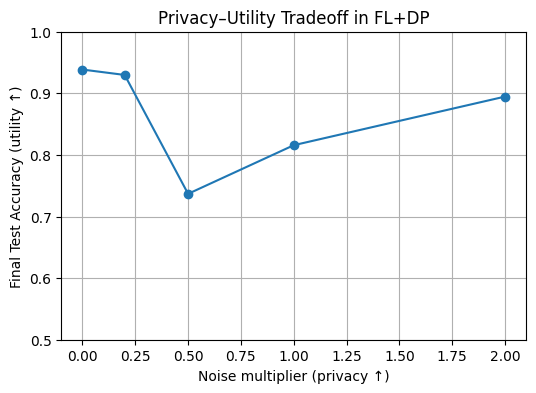

Final FL+DP accuracy: 0.8947368264198303


In [6]:
# fedavg_dp.py
"""
Federated Learning with Differential Privacy (FL+DP) on the Breast Cancer dataset.

Adds:
  1. Clipping client updates
  2. Adding Gaussian noise to the aggregated update
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(42)
np.random.seed(42)

# -----------------------
# Dataset
# -----------------------
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.int64)

# Standardize
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# -----------------------
# Simple model (MLP)
# -----------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden=32, out_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------------
# Federated training (FedAvg + DP)
# -----------------------
def fedavg_dp_train(num_clients=5, num_rounds=30, local_epochs=2,
                    clip_norm=1.0, noise_multiplier=1.0):
    # Split data IID among clients
    idxs = np.arange(len(X_train))
    np.random.shuffle(idxs)
    client_splits = np.array_split(idxs, num_clients)

    # Init global model
    global_model = SimpleMLP(X.shape[1])
    global_params = [p.detach().clone() for p in global_model.parameters()]

    test_accs = []

    for r in range(num_rounds):
        client_updates = []

        # Each client trains locally
        for split in client_splits:
            model = SimpleMLP(X.shape[1])
            # load global params
            for p, q in zip(model.parameters(), global_params):
                p.data.copy_(q)

            opt = optim.SGD(model.parameters(), lr=0.05)
            for _ in range(local_epochs):
                xb, yb = X_train[split], y_train[split]
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()

            # compute update
            local_params = [p.detach().clone() for p in model.parameters()]
            update = [lp - gp for lp, gp in zip(local_params, global_params)]

            # Clip update
            norm = torch.sqrt(sum([(u**2).sum() for u in update]))
            if norm > clip_norm:
                scale = clip_norm / (norm + 1e-10)
                update = [u * scale for u in update]

            client_updates.append(update)

        # Aggregate updates (average)
        agg_update = [sum(up[i] for up in client_updates) / num_clients
                      for i in range(len(global_params))]

        # Add Gaussian noise
        if noise_multiplier > 0:
            for i in range(len(agg_update)):
                noise = torch.normal(
                    0, noise_multiplier * clip_norm, size=agg_update[i].shape
                )
                agg_update[i] += noise / num_clients

        # Update global params
        global_params = [gp + au for gp, au in zip(global_params, agg_update)]

        # Evaluate on test set
        global_model.eval()
        with torch.no_grad():
            for p, q in zip(global_model.parameters(), global_params):
                p.data.copy_(q)
            preds = global_model(X_test).argmax(dim=1)
            acc = (preds == y_test).float().mean().item()
        test_accs.append(acc)

        print(f"Round {r+1}/{num_rounds} - Test Acc: {acc:.4f}")

    return test_accs

# -----------------------
# Run FL+DP with different noise multipliers
# -----------------------
noise_levels = [0.0, 0.2, 0.5, 1.0, 2.0]  # 0.0 = plain FL
final_accs = []

for sigma in noise_levels:
    print(f"\nRunning FL+DP with noise multiplier = {sigma}")
    accs = fedavg_dp_train(num_clients=5, num_rounds=30,
                           local_epochs=2,
                           clip_norm=1.0,
                           noise_multiplier=sigma)
    final_accs.append(accs[-1])

# -----------------------
# Plot Privacy–Utility tradeoff
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(noise_levels, final_accs, marker="o")
plt.xlabel("Noise multiplier (privacy ↑)")
plt.ylabel("Final Test Accuracy (utility ↑)")
plt.title("Privacy–Utility Tradeoff in FL+DP")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()
accs_fldp = accs   # keep the whole list for chosen noise level
acc_fldp = accs[-1]
 # pick noise=1.0 result
print("Final FL+DP accuracy:", acc_fldp)


Epoch 010 - Loss: 0.1179, Test Acc: 0.9649
Epoch 020 - Loss: 0.0861, Test Acc: 0.9474
Epoch 030 - Loss: 0.0749, Test Acc: 0.9474
Epoch 040 - Loss: 0.0793, Test Acc: 0.9474
Epoch 050 - Loss: 0.0598, Test Acc: 0.9474
Epoch 060 - Loss: 0.0560, Test Acc: 0.9561
Epoch 070 - Loss: 0.0572, Test Acc: 0.9474
Epoch 080 - Loss: 0.0582, Test Acc: 0.9474
Epoch 090 - Loss: 0.0427, Test Acc: 0.9474
Epoch 100 - Loss: 0.0458, Test Acc: 0.9561


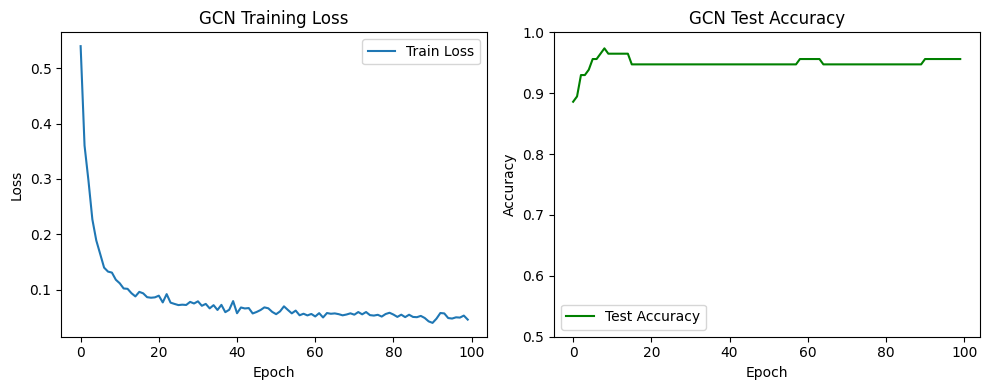

Final RL accuracy: 0.9561403393745422


In [7]:
# relational_gcn.py
"""
Relational Learning (GCN) on Breast Cancer dataset.
Builds a similarity graph of patients and applies GCN for node classification.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(42)
np.random.seed(42)

# -----------------------
# Dataset
# -----------------------
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.int64)

# Standardize
X = StandardScaler().fit_transform(X)

# Split into train/test nodes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Combine into one big graph (train+test nodes together)
X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([y_train, y_test])
n_train = len(X_train)
n_all = X_all.shape[0]

# Build similarity graph
k = 5
sim = cosine_similarity(X_all)
edges = []
for i in range(n_all):
    neighbors = np.argsort(sim[i])[-(k+1):-1]  # top-k (skip self)
    for j in neighbors:
        edges.append([i, j])
edges = np.array(edges).T  # shape [2, num_edges]

# -----------------------
# PyTorch Geometric setup
# -----------------------
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
except ImportError as e:
    raise ImportError("Please install torch-geometric to run this script.") from e

x = torch.tensor(X_all, dtype=torch.float)
y_t = torch.tensor(y_all, dtype=torch.long)
edge_index = torch.tensor(edges, dtype=torch.long)

# Masks: train on training nodes, test on test nodes
train_mask = torch.zeros(n_all, dtype=torch.bool)
train_mask[:n_train] = True
test_mask = torch.zeros(n_all, dtype=torch.bool)
test_mask[n_train:] = True

data_g = Data(x=x, edge_index=edge_index, y=y_t,
              train_mask=train_mask, test_mask=test_mask)

# -----------------------
# Define GCN model
# -----------------------
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# -----------------------
# Training loop
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(X_all.shape[1], hidden=32, out_dim=2).to(device)
data_g = data_g.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses, test_accs = [], []

for epoch in range(1, 101):
    model.train()
    opt.zero_grad()
    out = model(data_g.x, data_g.edge_index)
    loss = F.nll_loss(out[data_g.train_mask], data_g.y[data_g.train_mask])
    loss.backward()
    opt.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        out = model(data_g.x, data_g.edge_index)
        pred = out.argmax(dim=1)
        acc = (pred[data_g.test_mask] == data_g.y[data_g.test_mask]).float().mean().item()
        test_accs.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} - Loss: {loss:.4f}, Test Acc: {acc:.4f}")

# -----------------------
# Plots
# -----------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accs, label="Test Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN Test Accuracy")
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()
accs_rl = test_accs
acc_rl = test_accs[-1]
 # save the final GCN accuracy
print("Final RL accuracy:", acc_rl)


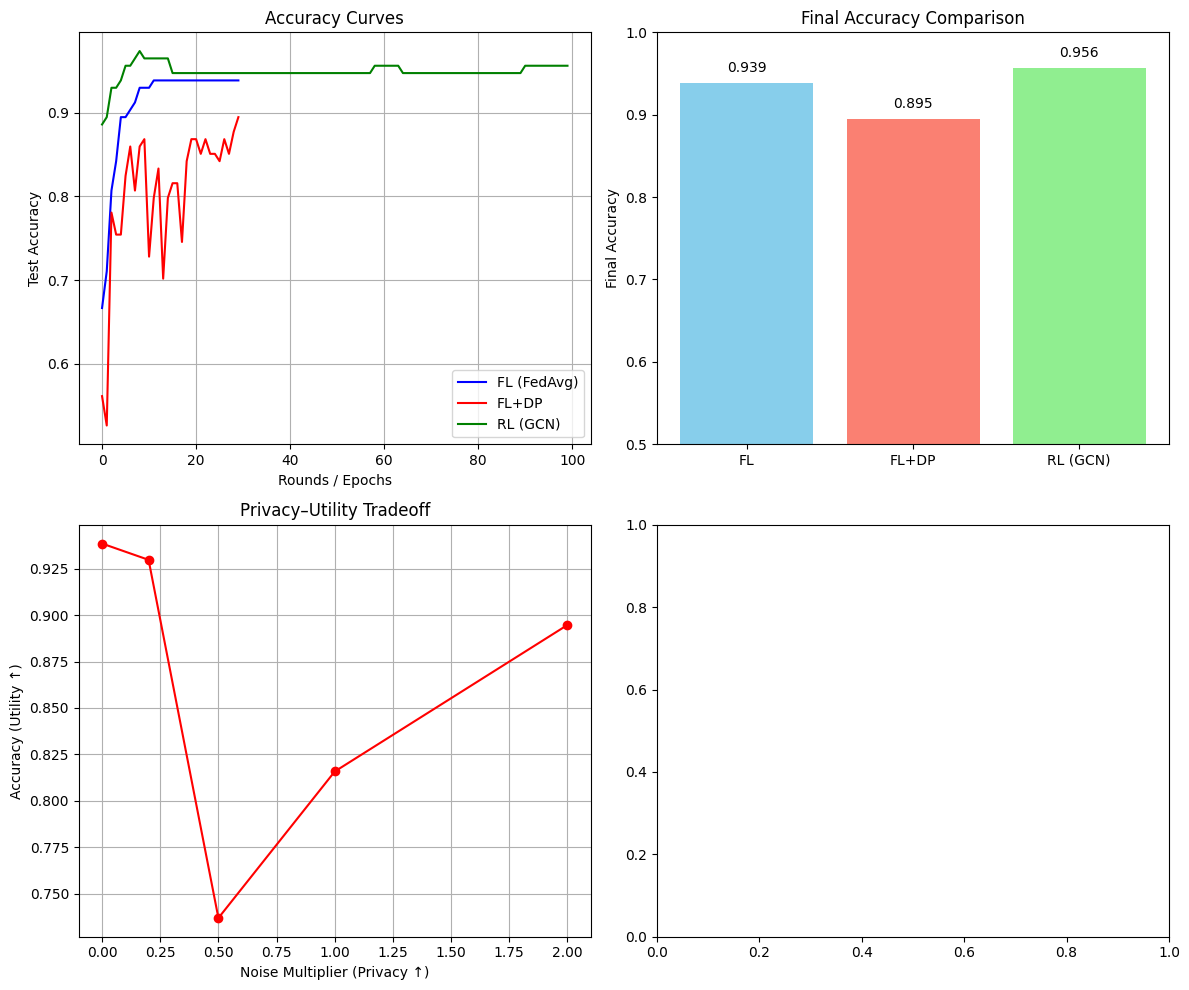

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2, 2, figsize=(12,10))

# -----------------------
# 1. Accuracy Curves
# -----------------------
axs[0,0].plot(accs_fl, label="FL (FedAvg)", color="blue")
axs[0,0].plot(accs_fldp, label="FL+DP", color="red")
axs[0,0].plot(accs_rl, label="RL (GCN)", color="green")
axs[0,0].set_xlabel("Rounds / Epochs")
axs[0,0].set_ylabel("Test Accuracy")
axs[0,0].set_title("Accuracy Curves")
axs[0,0].legend()
axs[0,0].grid(True)

# -----------------------
# 2. Final Accuracy Comparison
# -----------------------
labels = ["FL", "FL+DP", "RL (GCN)"]
vals = [acc_fl, acc_fldp, acc_rl]
bars = axs[0,1].bar(labels, vals, color=["skyblue","salmon","lightgreen"])
axs[0,1].set_ylim(0.5, 1.0)
axs[0,1].set_ylabel("Final Accuracy")
axs[0,1].set_title("Final Accuracy Comparison")
for bar, v in zip(bars, vals):
    axs[0,1].text(bar.get_x()+bar.get_width()/2, v+0.01, f"{v:.3f}",
                  ha="center", va="bottom")

# -----------------------
# 3. Privacy–Utility Tradeoff (FL+DP)
# -----------------------
axs[1,0].plot(noise_levels, final_accs, marker="o", color="red")
axs[1,0].set_xlabel("Noise Multiplier (Privacy ↑)")
axs[1,0].set_ylabel("Accuracy (Utility ↑)")
axs[1,0].set_title("Privacy–Utility Tradeoff")
axs[1,0].grid(True)

# # -----------------------
# # 4. RL Embeddings (t-SNE)
# # -----------------------
# model.eval()
# with torch.no_grad():
#     out = model(data_g.x, data_g.edge_index)
#     embeddings = out.cpu().numpy()
# emb_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# sc = axs[1,1].scatter(emb_2d[:,0], emb_2d[:,1],
#                       c=y_all, cmap="coolwarm", edgecolor="k")
# axs[1,1].set_title("GCN Node Embeddings (t-SNE)")
# fig.colorbar(sc, ax=axs[1,1], label="Class (0 = malignant, 1 = benign)")

# -----------------------
# Adjust layout
# -----------------------
plt.tight_layout()
plt.show()

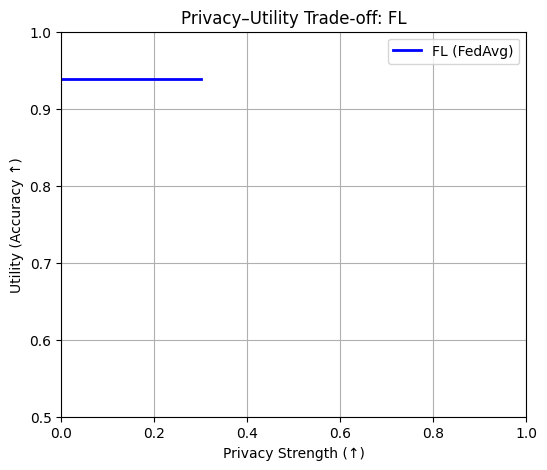

In [13]:
plt.figure(figsize=(6,5))
plt.plot([0, 0.3], [acc_fl, acc_fl], color="blue", linewidth=2, label="FL (FedAvg)")
plt.xlabel("Privacy Strength (↑)")
plt.ylabel("Utility (Accuracy ↑)")
plt.title("Privacy–Utility Trade-off: FL")
plt.ylim(0.5, 1.0)
plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.show()


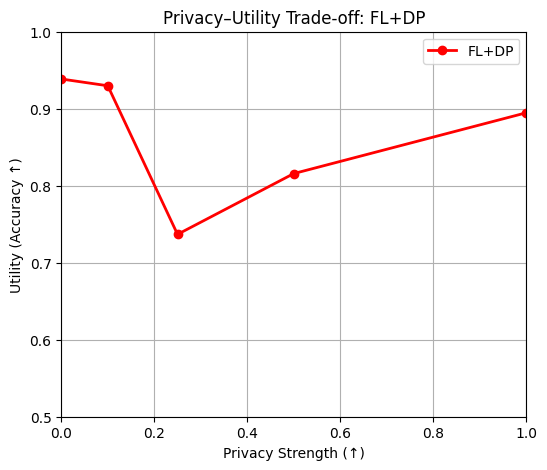

In [14]:
privacy_scores = [n / max(noise_levels) for n in noise_levels]

plt.figure(figsize=(6,5))
plt.plot(privacy_scores, final_accs, marker="o", color="red", linewidth=2, label="FL+DP")
plt.xlabel("Privacy Strength (↑)")
plt.ylabel("Utility (Accuracy ↑)")
plt.title("Privacy–Utility Trade-off: FL+DP")
plt.ylim(0.5, 1.0)
plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.show()

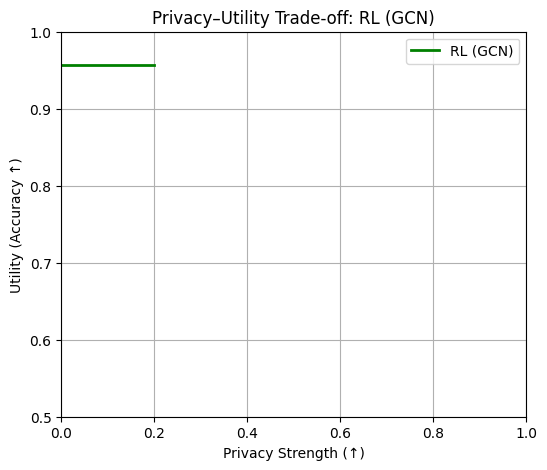

In [15]:
plt.figure(figsize=(6,5))
plt.plot([0, 0.2], [acc_rl, acc_rl], color="green", linewidth=2, label="RL (GCN)")
plt.xlabel("Privacy Strength (↑)")
plt.ylabel("Utility (Accuracy ↑)")
plt.title("Privacy–Utility Trade-off: RL (GCN)")
plt.ylim(0.5, 1.0)
plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.show()

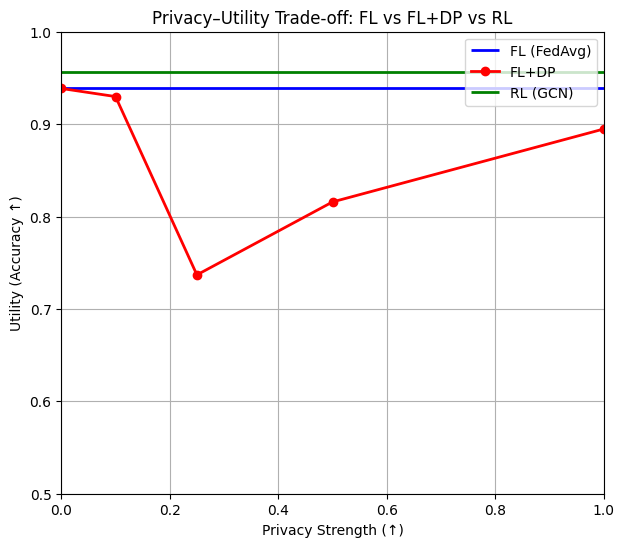

In [17]:
import matplotlib.pyplot as plt

# Normalize noise multipliers for FL+DP curve
privacy_scores = [n / max(noise_levels) for n in noise_levels]

plt.figure(figsize=(7,6))

# FL (horizontal line)
plt.hlines(acc_fl, xmin=0, xmax=1, colors="blue", linewidth=2, label="FL (FedAvg)")

# FL+DP (curve)
plt.plot(privacy_scores, final_accs, marker="o", color="red", linewidth=2, label="FL+DP")

# RL (horizontal line)
plt.hlines(acc_rl, xmin=0, xmax=1, colors="green", linewidth=2, label="RL (GCN)")

# Style
plt.xlabel("Privacy Strength (↑)")
plt.ylabel("Utility (Accuracy ↑)")
plt.title("Privacy–Utility Trade-off: FL vs FL+DP vs RL")
plt.ylim(0.5, 1.0)
plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.show()
